In [1]:
import os
import json
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import scipy.io.wavfile as wav
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# path = 'data/audioMNIST_meta.txt'
# file = open(path, 'r')
# data = file.read()

In [3]:
# print(data)

In [4]:
# data_dict = json.loads(data)

In [5]:
# data_dict

In [6]:
# data_frame = pd.DataFrame.from_dict(data_dict, orient='index')

In [7]:
# data_frame

### **Extracting MFCC some samples**

In [8]:
audio_files = sorted(glob('data/01/*_01_0.wav'))
audio_files

['data/01/0_01_0.wav',
 'data/01/1_01_0.wav',
 'data/01/2_01_0.wav',
 'data/01/3_01_0.wav',
 'data/01/4_01_0.wav',
 'data/01/5_01_0.wav',
 'data/01/6_01_0.wav',
 'data/01/7_01_0.wav',
 'data/01/8_01_0.wav',
 'data/01/9_01_0.wav']

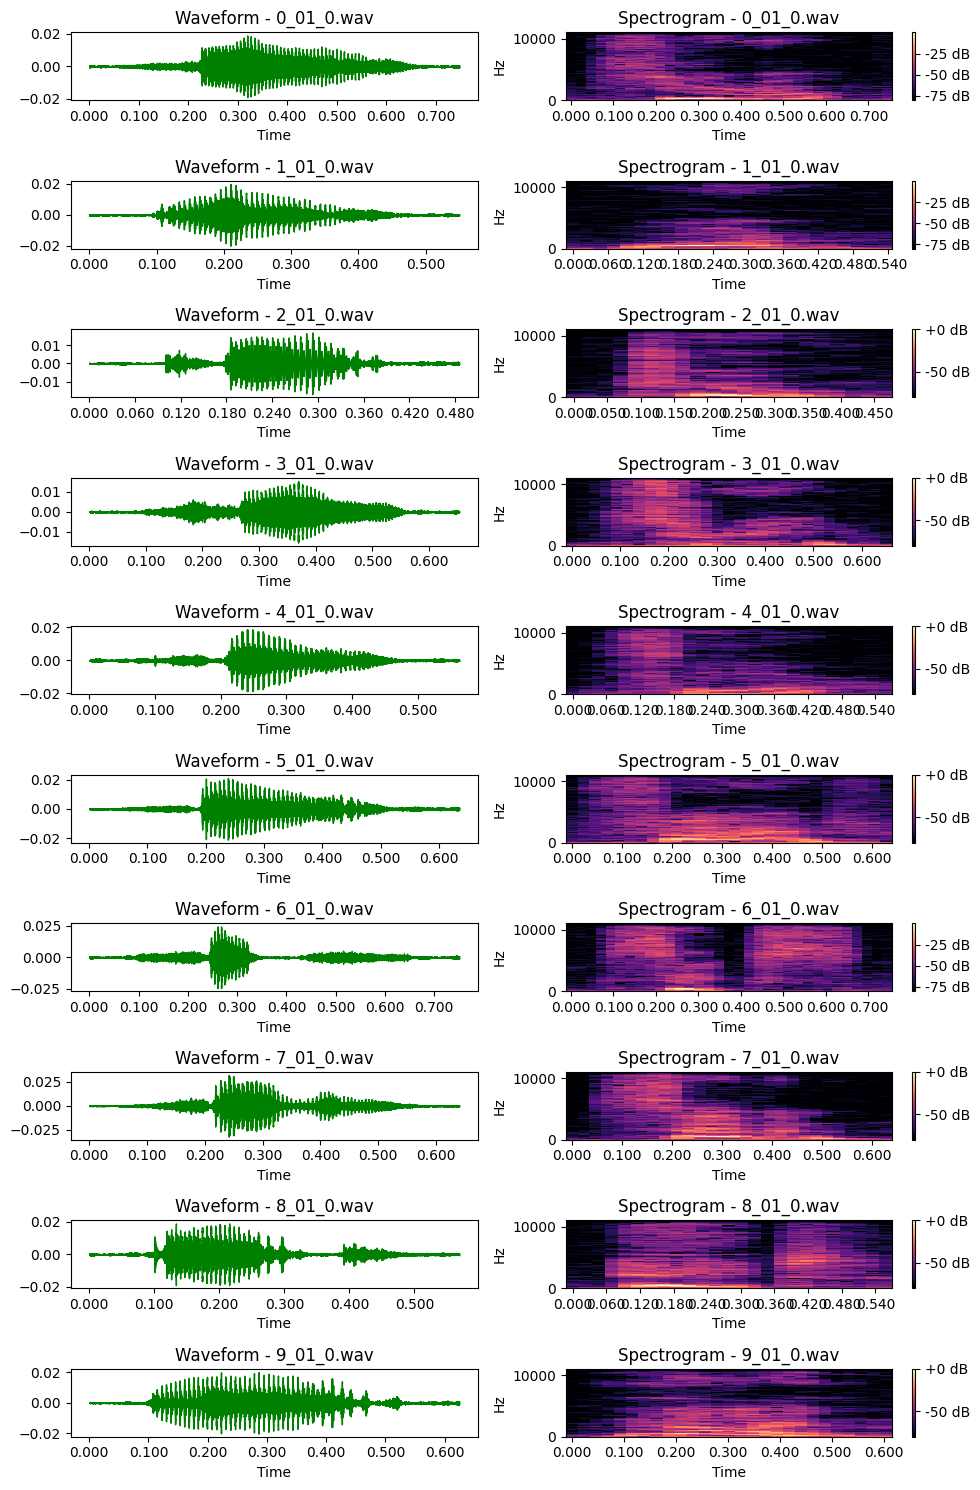

In [9]:
fig, axs = plt.subplots(10, 2, figsize=(10, 15))
axs_flat = axs.flatten()

for i, audio_file in enumerate(audio_files):  
    
    audio_data, sample_rate = librosa.load(audio_file)
    
    time_to_freq = librosa.stft(audio_data)
    S_db = librosa.amplitude_to_db(np.abs(time_to_freq), ref=np.max)
    
    librosa.display.waveshow(audio_data, sr=sample_rate, ax=axs_flat[i*2], color='green')
    axs_flat[i*2].set_title(f'Waveform - {audio_file.split("/")[-1]}')
    
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='hz', ax=axs_flat[i*2+1])
    axs_flat[i*2+1].set_title(f'Spectrogram - {audio_file.split("/")[-1]}')
    
    fig.colorbar(img, ax=axs_flat[i*2+1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

### **Building Dataset**

In [10]:
files = sorted(glob('data/*/**.wav'))

In [11]:
files

['data/01/0_01_0.wav',
 'data/01/0_01_1.wav',
 'data/01/0_01_10.wav',
 'data/01/0_01_11.wav',
 'data/01/0_01_12.wav',
 'data/01/0_01_13.wav',
 'data/01/0_01_14.wav',
 'data/01/0_01_15.wav',
 'data/01/0_01_16.wav',
 'data/01/0_01_17.wav',
 'data/01/0_01_18.wav',
 'data/01/0_01_19.wav',
 'data/01/0_01_2.wav',
 'data/01/0_01_20.wav',
 'data/01/0_01_21.wav',
 'data/01/0_01_22.wav',
 'data/01/0_01_23.wav',
 'data/01/0_01_24.wav',
 'data/01/0_01_25.wav',
 'data/01/0_01_26.wav',
 'data/01/0_01_27.wav',
 'data/01/0_01_28.wav',
 'data/01/0_01_29.wav',
 'data/01/0_01_3.wav',
 'data/01/0_01_30.wav',
 'data/01/0_01_31.wav',
 'data/01/0_01_32.wav',
 'data/01/0_01_33.wav',
 'data/01/0_01_34.wav',
 'data/01/0_01_35.wav',
 'data/01/0_01_36.wav',
 'data/01/0_01_37.wav',
 'data/01/0_01_38.wav',
 'data/01/0_01_39.wav',
 'data/01/0_01_4.wav',
 'data/01/0_01_40.wav',
 'data/01/0_01_41.wav',
 'data/01/0_01_42.wav',
 'data/01/0_01_43.wav',
 'data/01/0_01_44.wav',
 'data/01/0_01_45.wav',
 'data/01/0_01_46.wav

In [12]:
X, y = [], []
for file in files:
    X.append(file)
    y.append(file.split('/')[-1].split('_')[0])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)
print(len(X_train), len(X_test), len(X_val), len(y_train), len(y_test), len(y_val), sep='\n')

22950
3000
4050
22950
3000
4050


In [14]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.audio = X
        self.labels = y
        assert (len(self.audio) == len(self.labels))
        self.max_len = 45
    def __len__(self):
        return len(self.audio)

    def pad_mfcc(self, mfcc, max_len):
        # Get the current length of the mfcc
        current_len = mfcc.shape[1]
        if current_len < max_len:
            # Calculate the amount of padding needed
            pad_width = max_len - current_len
            # Pad the mfcc with zeros
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        elif current_len > max_len:
            mfcc = mfcc[:, :max_len]
        return mfcc

    
    def mfcc_data(self, file):
        audio, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=0)
        mfcc_std = np.std(mfcc, axis=0)
        mfcc_normalized = (mfcc - mfcc_mean) / mfcc_std
        mfcc_normalized = self.pad_mfcc(mfcc_normalized, self.max_len)
        return mfcc_normalized
    
    def __getitem__(self, idx):
        audio_seq = self.mfcc_data(self.audio[idx])
        label = torch.tensor(int(self.labels[idx]))
        
        audio_seq = torch.tensor(audio_seq).to(dtype=torch.float32)
        return audio_seq, label

In [15]:
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [16]:
next(iter(train_dataloader))[0].shape

torch.Size([4, 13, 45])

### **Building Model**

In [17]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv1d(13, 32, kernel_size=3, stride=1, padding=0)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Tính toán kích thước đầu ra
        self.flatten_size = self._get_flatten_size()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def _get_flatten_size(self):
        # Tạo một tensor giả với kích thước đầu vào ban đầu
        x = torch.zeros(1, 13, 45)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        return x.numel()
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [18]:
num_classes = 10
model = AudioClassifier(num_classes)
optimizer = Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.NLLLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 50

In [19]:
device

'cuda'

In [20]:
def train(model, optimizer, loss_fn, train_dataloader, val_dataloader, device, epochs):
    model = model.to(device).to(torch.float32)
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        train_loss = 0.0
        model.train()
        for X_train, y_train in train_dataloader:
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            y_pred = model(X_train)
            
            optimizer.zero_grad()
            
            loss = loss_fn(y_pred, y_train)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        train_loss_average = train_loss / len(train_dataloader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_dataloader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                
                y_pred = model(X_val)

                loss = loss_fn(y_pred, y_val)
                val_loss += loss.item()
        val_loss_average = val_loss / len(val_dataloader)
        
        print(f'Epoch {epoch} | Training Loss: {train_loss_average} | Validation Loss: {val_loss_average}')
        
        train_losses.append(train_loss_average)
        val_losses.append(val_loss_average)
    
    plt.figure(figsize=(15, 25))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title('Trainig Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return train_losses, val_losses
        

In [21]:
train_losses, val_losses = train(model, optimizer, loss_fn, train_dataloader, val_dataloader, device, epochs)

Epoch 0 | Training Loss: 0.8439242983172879 | Validation Loss: 0.3187006025209422
Epoch 1 | Training Loss: 0.23507347310743285 | Validation Loss: 0.21715661711799605
Epoch 2 | Training Loss: 0.15146682172482362 | Validation Loss: 0.12389212800696943
Epoch 3 | Training Loss: 0.11214824914700532 | Validation Loss: 0.10572298008560548
Epoch 4 | Training Loss: 0.08814584884030223 | Validation Loss: 0.07936443224590783
Epoch 5 | Training Loss: 0.06881386571652187 | Validation Loss: 0.06106806303515277


KeyboardInterrupt: 

In [22]:
def evaluation(model, loss_fn, test_dataloader, device):
    model = model.to(device).to(torch.float32)
    model.eval()
    y_true = []
    y_preds = []
    total = 0.0
    correct = 0.0
    for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        
        outputs = model(X_test)
        _, y_pred = torch.max(outputs, 1)

        total += y_test.size(0)
        correct += (y_pred == y_test).sum().item()

        y_true.extend(y_pred.cpu().numpy())
        y_preds.extend(y_pred.cpu().numpy())        
    
    accuracy = 100 * correct / total

    print(f'Accuracy in test set {accuracy:2f}%')

    cm = confusion_matrix(y_true, y_preds)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy in test set 98.366667%


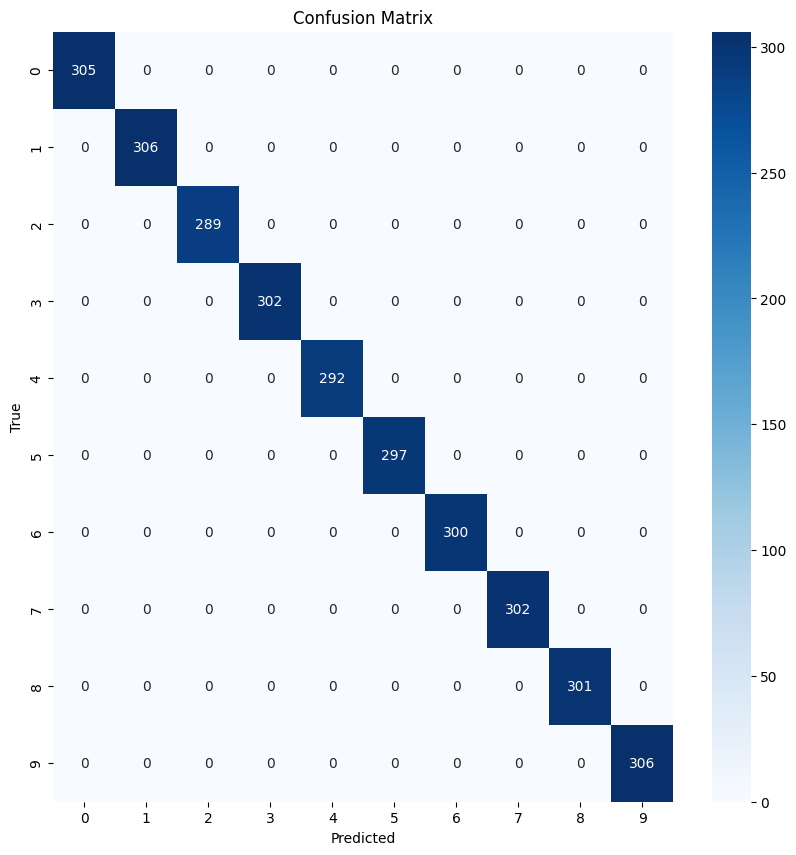

In [23]:
evaluation(model, loss_fn, test_dataloader, device)

In [26]:
torch.save(model.state_dict(), 'model.pt')

: 